# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from dataset.data import (
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    RegionSpecNegAugment,
    InteractionSelectionPolicy,
    EasyPosAugment,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    RegionSpecNegAugment,
    plot_sample,
    seed_everything,
)
from train_binary_cl import seed_worker

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_files_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')

In [4]:
df = pd.read_csv(os.path.join(processed_files_dir,"df_annotation_files_cleaned.csv"))

/home/gbini/miniconda3/envs/rnarna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Esecuzione data loader train

In [191]:
pos_width_multipliers = {4: 0.05, 10: 0.1, 14: 0.15, 17: 0.1, 19: 0.3, 21: 0.3}
pos_height_multipliers = pos_width_multipliers

neg_width_windows = {(50, 150): 0.05, (150, 170): 0.12, (170, 260): 0.05, (260, 350): 0.15, (350, 450): 0.28, (450, 511): 0.1, (511, 512): 0.25}
neg_height_windows = neg_width_windows

regionspec_multipliers = pos_width_multipliers
regionspec_windows = neg_width_windows

assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1

policies_train = [
        EasyPosAugment(
            per_sample=8,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=regionspec_multipliers,
            height_multipliers=regionspec_multipliers,
        ),
        EasyNegAugment(
            per_sample=2,
            width_windows=neg_width_windows,
            height_windows=neg_height_windows,
        ),
        HardPosAugment(
            per_sample=3,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
        ),
        HardNegAugment(
            per_sample=3,
            width_windows=neg_width_windows,
            height_windows=neg_height_windows,
        ),
        RegionSpecNegAugment(
        per_sample=7,
        width_windows=regionspec_multipliers,
        height_windows=neg_height_windows,
    ),
]
    
    
dataset_train = RNADataset(
    gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
        interactions_path=os.path.join(
            processed_files_dir, "df_annotation_files_cleaned.csv"
        ),
        dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
        subset_file=os.path.join(
            rna_rna_files_dir, "gene_pairs_training_random_filtered.txt"
        ),
    augment_policies=policies_train
)

/tmp/ipykernel_30215/2489940218.py:34: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_train = RNADataset(


#### Let s start with the training set

In [192]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/293760 [00:00<?, ?it/s]

  0%|          | 0/293760 [00:00<?, ?it/s]

  0%|          | 0/293760 [00:00<?, ?it/s]

In [193]:
df_len.label.value_counts()

n    892680
p    869880
Name: label, dtype: int64

In [194]:
df_len.sort_values('length').head(500).label.value_counts()

p    270
n    230
Name: label, dtype: int64

In [195]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.01

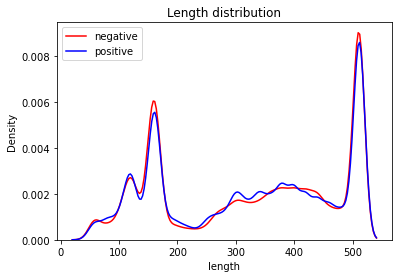

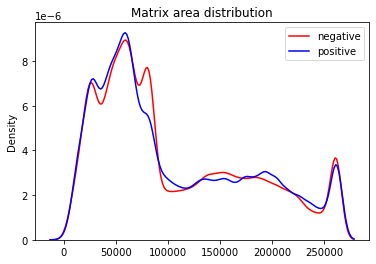

In [196]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

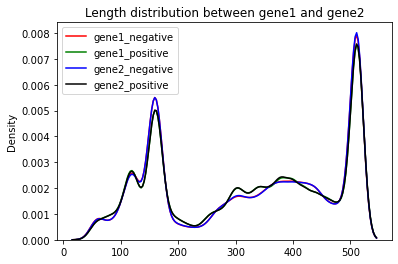

In [197]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [188]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.8)
print(df_len[df_len['length'] > big_l].label.value_counts())

p    87818
n    84495
Name: label, dtype: int64


n    182982
p    169017
Name: label, dtype: int64


# Validation set 

In [68]:
pos_width_multipliers_val = {3: 0.01, 19: 0.29, 21: 0.7}
pos_height_multipliers_val = pos_width_multipliers_val

neg_width_windows_val = {(50, 100): 0.05, (100, 160): 0.2, (160, 260): 0.05, (260, 350): 0.2, (350, 450): 0.25, (450, 511): 0.1, (511, 512): 0.15}
neg_height_windows_val = neg_width_windows_val

regionspec_multipliers_val = pos_width_multipliers_val
regionspec_windows_val = neg_width_windows_val

assert np.round(sum(pos_width_multipliers_val.values()), 4) == np.round(sum(neg_width_windows_val.values()), 4) == 1    


policies_val = [
        EasyPosAugment(
            per_sample=6,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=regionspec_multipliers_val,
            height_multipliers=regionspec_multipliers_val,
        ),
        EasyNegAugment(
            per_sample=4,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        HardPosAugment(
            per_sample=2,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        HardNegAugment(
            per_sample=4,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        RegionSpecNegAugment(
        per_sample=2,
        width_windows=regionspec_multipliers_val,
        height_windows=neg_height_windows_val,
    ),
]

dataset_val = RNADataset(
    gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
        interactions_path=os.path.join(
            processed_files_dir, "df_annotation_files_cleaned.csv"
        ),
        dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
        subset_file=os.path.join(
            rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"
        ),
    augment_policies=policies_val
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

/tmp/ipykernel_24630/1514957326.py:52: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_val = RNADataset(


In [69]:
g = torch.Generator()
g.manual_seed(0)
data_loader_val = DataLoader(dataset_val, 32,
                             sampler=sampler_val, drop_last=False,
                             collate_fn=utils.collate_fn,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in data_loader_val:
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [70]:
df_len.label.value_counts()

n    6988
p    6848
Name: label, dtype: int64

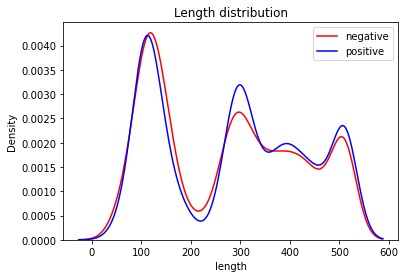

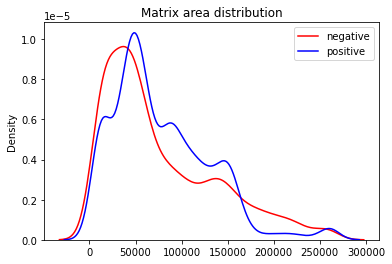

In [71]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

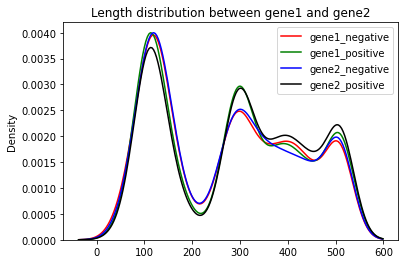

In [72]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

# Test 

In [5]:
pos_width_multipliers_test = {3: 0.01, 19: 0.29, 21: 0.7}
pos_height_multipliers_test = pos_width_multipliers_test

neg_width_windows_test = {(50, 100): 0.05, (100, 160): 0.2, (160, 260): 0.05, (260, 350): 0.2, (350, 450): 0.25, (450, 511): 0.1, (511, 512): 0.15}
neg_height_windows_test = neg_width_windows_test

regionspec_multipliers_test = pos_width_multipliers_test
regionspec_windows_test = neg_width_windows_test

assert np.round(sum(pos_width_multipliers_test.values()), 4) == np.round(sum(neg_width_windows_test.values()), 4) == 1    


policies_test = [
        EasyPosAugment(
            per_sample=6,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=regionspec_multipliers_test,
            height_multipliers=regionspec_multipliers_test,
        ),
        EasyNegAugment(
            per_sample=4,
            width_windows=neg_width_windows_test,
            height_windows=neg_height_windows_test,
        ),
        HardPosAugment(
            per_sample=2,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers_test,
            height_multipliers=pos_height_multipliers_test,
        ),
        HardNegAugment(
            per_sample=4,
            width_windows=neg_width_windows_test,
            height_windows=neg_height_windows_test,
        ),
        RegionSpecNegAugment(
        per_sample=2,
        width_windows=regionspec_multipliers_test,
        height_windows=neg_height_windows_test,
    ),
]

dataset_test = RNADataset(
    gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
        interactions_path=os.path.join(
            processed_files_dir, "df_annotation_files_cleaned.csv"
        ),
        dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
        subset_file=os.path.join(
            rna_rna_files_dir, "gene_pairs_test_random_filtered.txt"
        ),
    augment_policies=policies_test
)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)

/tmp/ipykernel_1116/52277612.py:45: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_test = RNADataset(


In [6]:
g = torch.Generator()
g.manual_seed(0)
data_loader_test = DataLoader(dataset_test, 32,
                             sampler=sampler_test, drop_last=False,
                             collate_fn=utils.collate_fn,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in data_loader_test:
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [7]:
df_len.label.value_counts()

n    14508
p    14016
Name: label, dtype: int64

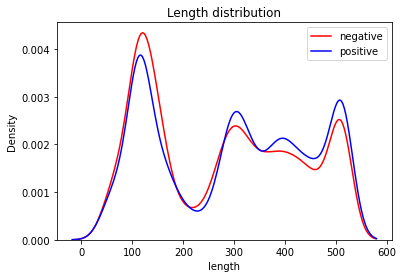

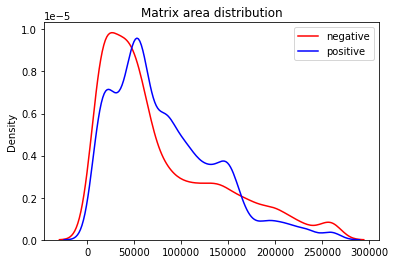

In [8]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()